##  Исследование продаж компьютерных игр

В нашем распоряжении датасет с данными о продажах компьютерных игр. Фичи - исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).  
**Цель:**   
Нужно выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  

**Ход исследования:**  
1. Подготовка данных. Данные предоставлены платформой в виде файла. О данных ничего не известно, поэтому предварительно их оценим на пропуски, дубликаты, выбросы.  
2. Исследовательский анализ данных. Посмотрим различные закономерности между признаками.  
3. Составим портрет пользователя в зависимости от региона (NA, EU, JP).  
4. Проверим гипотезы:  
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

#from pandas_profiling import ProfileReport

import re
import time
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 50)

In [2]:
# functions place

def get_soup(url):
    """
    на вход ссылка
    имитируем поведение браузера
    возвращаем объект - 'супчик'
    """
  
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
            #'User-Agent': '*',
             'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
             'Accept-Language': 'en-US,en;q=0.5',
             'Accept-Encoding': 'gzip, deflate',
             'Connection': 'keep-alive',
             'Upgrade-Insecure-Requests': '1',
            }
    
    try:
        s = requests.Session()
        s.headers.update(headers)
        r = s.get(url,allow_redirects=False)
    except:
        return 0
    if r.status_code != 200:
        return 0
    else:
        return BeautifulSoup(r.text, 'html.parser')
    

def f_look_category_feature(data, feature):
    (
    data.groupby(feature)
    [feature].agg(['count'])
    .sort_values(by='count', ascending=False)
    .plot(kind='bar', figsize=(15,7))
    )

def make_plot(data, feature, sales='total_sales', years='year_of_release', year_min=1990, year_max=2016, lim=0.1):
    """
    Строим график признака по годам
    """
    # сгруппируем по признаку, по умолчанию total_sales, 
    gr_feature = data.groupby(feature).agg({sales:'sum'}).sort_values(by=sales, ascending=False)
    pop_features = gr_feature[:12].index.to_list()
    
    # строим график
    plt.figure(figsize=(15, 7))
    for sign in pop_features:
        feature_per_year = (
                            data.loc[data[feature]==sign][[years, sales]]
                            .groupby(years)
                            .agg({sales:'sum'})
                            )
        #plt.plot(feature_per_year[feature_per_year[sales] > feature_per_year[sales].quantile(lim)], label = sign)
        plt.plot(feature_per_year, label = sign)

    plt.xticks(data.year_of_release.unique(), rotation=45)
    plt.xlim(year_min, year_max)
    plt.legend()
    plt.grid(linestyle='-');


region_sales = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

def check_region(data, region, feature):
    reg_feature = data.groupby(feature).agg({region:'sum'}).sort_values(by=region, ascending=False).head()
    reg_feature.plot(kind='bar')
    plt.show()
    reg_feature['percents'] = round(100*reg_feature[region]/reg_feature[region].sum(),1)
    display(reg_feature[['percents']])

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def print_mesures(serie):
    print(f"""Меры для {namestr(serie, globals())[0]} 
     медиана - {serie.describe().iloc[5].round(2)}
     среднее - {serie.describe().iloc[1].round(2)}
     минимум - {serie.describe().iloc[3].round(2)}
     максимум - {serie.describe().iloc[7].round(2)}
     стандартное отклонение - {serie.describe().iloc[2].round(2)}
     """)
    print('-'*60)


In [3]:
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')
df = data.copy() # оставим себе копию для проверки
data.sample(2)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
7777,Conflict: Denied Ops,X360,2008.0,Shooter,0.08,0.09,0.0,0.02,52.0,4.9,M
13953,Crypt Killer,PS,1997.0,Shooter,0.02,0.01,0.0,0.00,NaN,NaN,NaN


### Описание данных
- Name — название игры  
- Platform — платформа  
- Year_of_Release — год выпуска  
- Genre — жанр игры  
- NA_sales — продажи в Северной Америке (миллионы проданных копий)  
- EU_sales — продажи в Европе (миллионы проданных копий)  
- JP_sales — продажи в Японии (миллионы проданных копий)  
- Other_sales — продажи в других странах (миллионы проданных копий)  
- Critic_Score — оценка критиков (максимум 100)  
- User_Score — оценка пользователей (максимум 10)  
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [4]:
# посмотрим на датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


- Видим, что в датасете 16.7 тыс строк.
- Много пропусков (40-50%) в ранговых оценках: Critic_Score, User_Score, Rating
- В остальных признаках пропусков немного
- Год релиза зачем то имеет тип float
- Рейтинговые оценки Rating и User_Score почему то в формате object

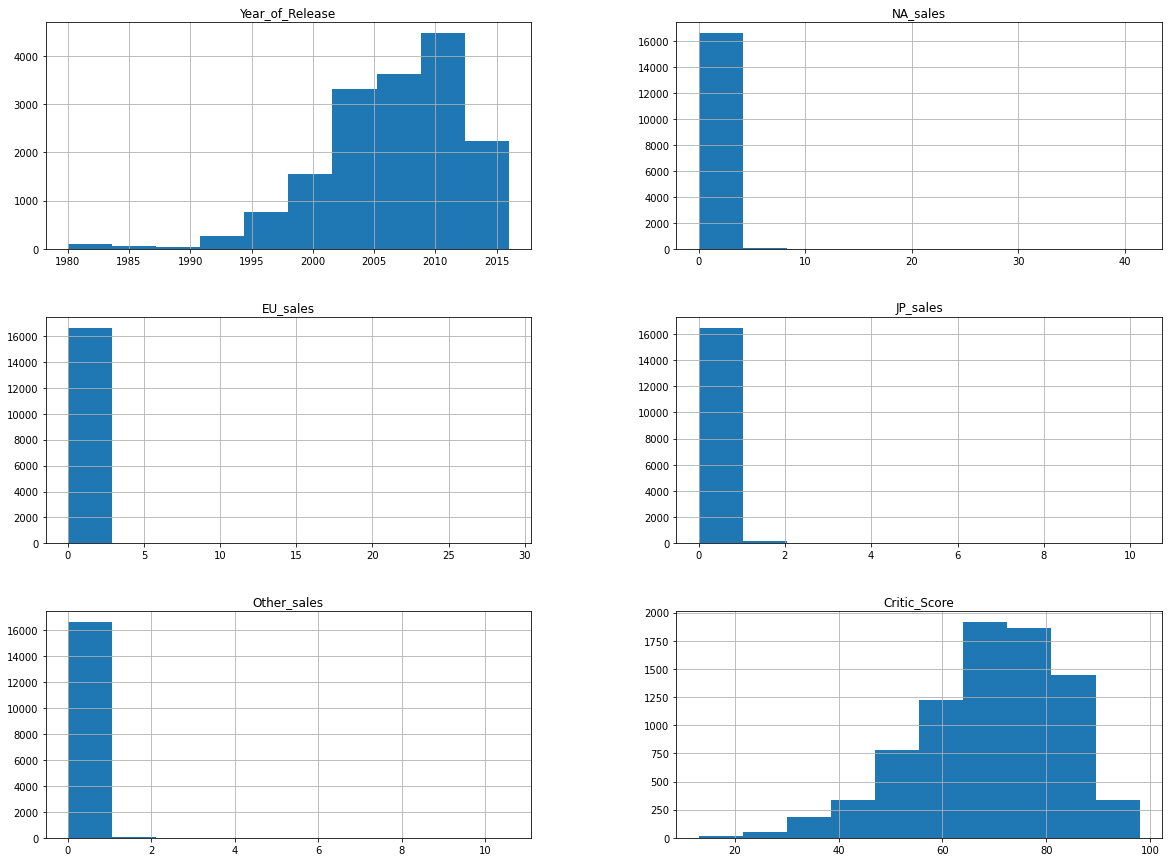

In [5]:
# посмотрим на гистограммы, но данных таким образом немного. Смотреть надо каждый признак индивидуально
# и следующий примененный метод подходит для этого намного лучше
data.hist(figsize=(20,15));


In [6]:
# Мне больше нравится метод ProfileReport из pandas_profiling. Дает более полное первичное описание признаков
#profile = ProfileReport(data)
# profile

In [7]:
# скинем отчет в отдельный html файл для удобства
#profile.to_file(r"first_look_games_sales.html")

### Предобработка

In [8]:
# Приведём названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [9]:
# Посмотрим на полные дубликаты.
data.duplicated().sum()

0

Видим, что полных дубликатов в датасете нет.  
Теперь помотрим на каждый признак индивидуально

**name**  
Название игры.

In [10]:
# Есть два пропуска у каких-то игр 93-го года. Кстати у них же пропуски и в столбце жанр. 
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [11]:
# Не надо нам такие безымянные игры 
data = data[~data['name'].isna()]

In [12]:
# Всего уникальных значений
data['name'].nunique()

11559

In [13]:
# Посмотрим на повторения самых популярных игр (популярных в плане частого повторения в name)
often_names = data['name'].value_counts().index[0:3] 
data[data['name'].isin(often_names)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
126,FIFA 14,PS3,2013.0,Sports,0.78,4.24,0.07,1.37,86.0,4.3,E
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
271,FIFA 14,X360,2013.0,Sports,0.92,2.89,0.01,0.40,84.0,4.2,E
469,FIFA 14,PS4,2013.0,Sports,0.61,1.85,0.11,0.44,87.0,6.3,E
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
730,LEGO Marvel Super Heroes,X360,2013.0,Action,1.24,0.79,0.00,0.19,80.0,7.6,E10+
945,LEGO Marvel Super Heroes,PS3,2013.0,Action,0.77,0.76,0.01,0.29,82.0,7.9,E10+
1139,LEGO Marvel Super Heroes,PS4,2013.0,Action,0.59,0.76,0.01,0.26,83.0,7.7,E10+
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T


Видим, что повторяющиеся игры представлены на разных платформах, а так же могут иметь разные годы релиза (ремейки)

In [14]:
# И ради интереса посмотрим топ-5 самых продаваемых игр (посмотрим по америке)
data.groupby('name')['na_sales'].sum().sort_values(ascending=False).head()

name
Wii Sports            41.36
Super Mario Bros.     32.48
Duck Hunt             26.93
Tetris                26.17
Grand Theft Auto V    23.84
Name: na_sales, dtype: float64

Видим, что тетрис и супер марио порвали даже ГТА 5 ))

**platform**  
Платформа для которой была выпущена игра. (Пропусков нет, тип - object)

In [15]:
# количество платформ
data['platform'].nunique()

31

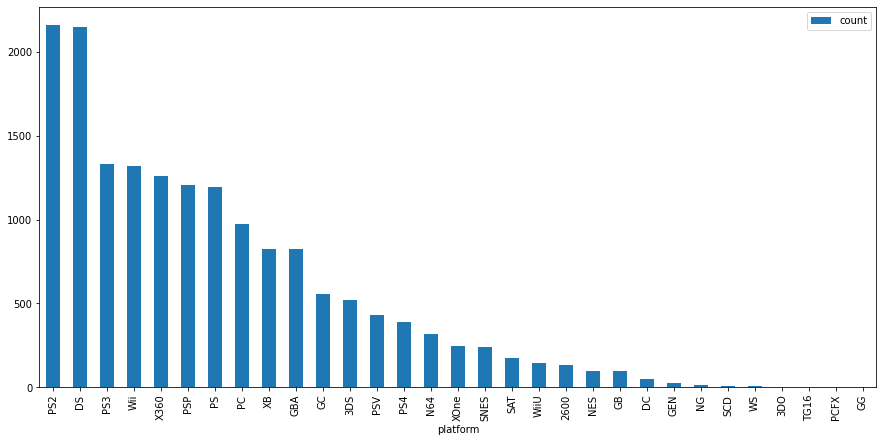

In [16]:
# посмотрим количество игровых платформ, которые придумало человечество  на графике (ну и количество выпущенных для них игр)
f_look_category_feature(data, 'platform')

Однако PC далеко (ну не очень конечно) не первый, а занимаает в этом вопросе почетное 7ое место. Так же есть платформы для которых выпущены по одной игре.  
есть мысль в дальнейшем объединить непопулярные платформы в одну, типа 'others', но надо чуть глубже покопать индустрию, может это какие то новые разработки с огромной перспективой развития.

In [17]:
# Посмотрим на хвостик (непопулярные платформы)
not_popular_platforms = data.groupby('platform')['platform'].agg(['count']).sort_values(by='count').head().index
data[data['platform'].isin(not_popular_platforms)]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3926,Final Fantasy,WS,2000.0,Role-Playing,0.0,0.0,0.51,0.0,NaN,NaN,NaN
6110,Digimon Adventure: Anode Tamer,WS,1999.0,Role-Playing,0.0,0.0,0.28,0.0,NaN,NaN,NaN
6650,Final Fantasy II,WS,2001.0,Role-Playing,0.0,0.0,0.25,0.0,NaN,NaN,NaN
8039,Chocobo no Fushigi Dungeon for WonderSwan,WS,1999.0,Role-Playing,0.0,0.0,0.18,0.0,NaN,NaN,NaN
8294,Super Robot Taisen Compact 2 Dai-1-Bu,WS,2000.0,Strategy,0.0,0.0,0.17,0.0,NaN,NaN,NaN
9223,Doukyuusei,TG16,1995.0,Adventure,0.0,0.0,0.14,0.0,NaN,NaN,NaN
12663,Policenauts,3DO,1995.0,Adventure,0.0,0.0,0.06,0.0,NaN,NaN,NaN
13571,Sonic the Hedgehog 2 (8-bit),GG,1992.0,Platform,0.0,0.0,0.04,0.0,NaN,NaN,NaN
14224,SD Gundam G Generation: Gather Beat 2,WS,2001.0,Strategy,0.0,0.0,0.03,0.0,NaN,NaN,NaN
14634,Blue Breaker: Ken Yorimo Hohoemi o,PCFX,1996.0,Role-Playing,0.0,0.0,0.03,0.0,NaN,NaN,NaN


Да, видим, что продажи были небольшие, только в японии, и игры лохматых годов, что подтверждает догадку о том, что такие платформы, которые "не выстрелили" скорее всего будет логично объединить в один тип, например, 'loosers'

**year_of_release**  
Год выпуска игры. 
Здесь сразу бросается в глаза, что тип float не подходит для данного признака. А так же небольшое(чуть меньше трехсот) наличие пропусков

In [18]:
# поменять тип при наличии пропусков в принципе можно, но не нужно. Сначала заполним пропуски, а потом изменим и тип признака
games_lost_years = data[data['year_of_release'].isna()]['name'].unique()

# Лучше день потерять потом за пять минут долететь. Парсим Wiki
path = 'https://en.wikipedia.org/wiki/'

#urls = []
games_found = {}
for game in games_lost_years:
    url = path + game.replace(' ', '_')
    #urls.append(url)
    try:
        soup = get_soup(url)
        My_table = soup.find('table').text.split('Release')[1]
        My_table = My_table.replace('\n', '')
        match = re.search('\d\d\d\d', My_table) 
        games_found[game] = int(match[0])
        time.sleep(0.1)
    except:
        try:
            soup = get_soup(url+'_(video_game)')
            My_table = soup.find('table').text.split('Release')[1]
            My_table = My_table.replace('\n', '')
            match = re.search('\d\d\d\d', My_table) 
            games_found[game] = int(match[0])
            time.sleep(0.1)
        except:
            games_found[game] = np.nan
            time.sleep(0.1)

# итого получилось спарсить:
count = 0
for i,j in games_found.items():
    if j is not np.nan:
        count += 1
print("удалось спарсить: ", count)

удалось спарсить:  130


In [19]:
# в некоторых названиях есть год, предположительно год выпуска. Возьмем его за основу для даты релиза
count = 0
for i,j in games_found.items():
    if j is np.nan:
        try:
            match = re.search('\d{4}', i) 
            games_found[i] = int(match[0])
        except:
            continue

In [20]:
# Заполним пропуски спарсенными данными
for i in range(data.shape[0]):
    if data['year_of_release'].iloc[i] > 1900:
        continue
    else:
        data['year_of_release'].iloc[i] = games_found[data['name'].iloc[i]]

print('Итого осталось пропусков: ', data['year_of_release'].isna().sum())

Итого осталось пропусков:  99


In [21]:
# Осталось 99 пропусков. Попробуем заполнить их данными, если у такой игры уже был выход на другой платформе - этим же годом
# у большинства игр выход на разных когсолях зачастую совпадает

data.loc[data['year_of_release'].isna(), 'year_of_release'] = \
        data.loc[data['year_of_release'].isna(), 'name'].map(data.groupby('name')['year_of_release'].first())

data['year_of_release'].isna().sum()

73

In [22]:
# Остаток, который не получилось заполнить - удалим и поменяем тип данных на int
data = data[~data['year_of_release'].isna()]
data['year_of_release'] = data['year_of_release'].astype('int')


Что можно сказкать предварительно по этому признаку. В идеале (в реальной жизни) - выяснить причину пропусков. Техническая ошибка или какая то другая. Их немного, можно было сразу убрать, но для тренировки попробовали: парсинг, заполнили датой если она была в названии, и заполнили датой, если уже была информация о дате на другой платтформе.

**genre**  
Жанр игры. Пропусков нет. Тип Object

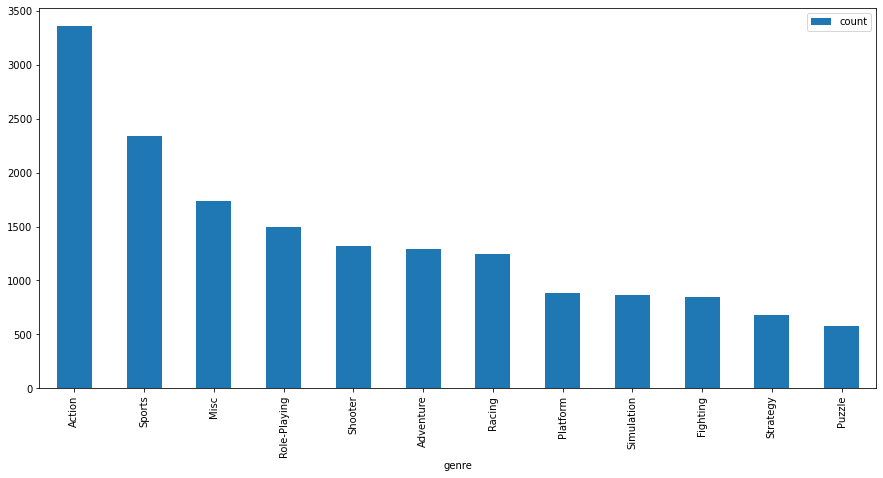

In [23]:
f_look_category_feature(data, 'genre')

Ничего неадекватного не видно. Самый популярный жанр - Action, самый не популярный - puzzle. Моё любимое RPG на 4ом месте

**na_sales**  
**eu_sales**  
**jp_sales**   
**other_sales**

По сути - целевые переменные. А именно продажи в америке, европе, японии и других странах.  
Пропусков нет. Тип float. Тут интересно посмотреть предварительно - какой из регионов является доминирующим по продажам, чтобы понять не какую аудиторию делать акцент в продажах.


<AxesSubplot:title={'center':'Regions Sales'}>

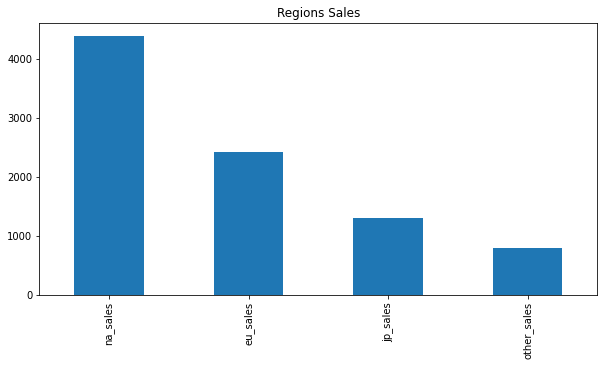

In [24]:
data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().plot(kind='bar', figsize=(10,5), title='Regions Sales')

Видим, что примерно половина всех продаж приходится на америку (северную). Примерно половина всех продаж.

**critic_score**  
**user_score**  
Рейтинговые очки критиков и пользователей. Очень много пропусков почти до 60%по рейтнгу пользователей. Тип  float и Object. Возможно многие игры очень непопулярные и просто не попадают в рейтинг.  
Предварительно можно посмотреть:    
- сколько продаж приходится на игры с рейтингом и без по разным регионам  
- насколько пересекается отсутствие рейтинга по разным форматам между собой
- какая между рейтингом пользователей и критиков корреляция

In [25]:
# добавим столбец, в котором будет указано, если игра вообще отсутствует в каком либо рейтинге
data['unpopular'] = (data['critic_score'].isna()) & ((data['user_score'].isna())|(data['user_score']=='tbd'))
data['unpopular'].value_counts(normalize=True).round(2)


False    0.52
True     0.48
Name: unpopular, dtype: float64

Видим, что почти половина игр отстутствует в любом рейтинге.

In [26]:
# добавим столбец с общими продажами
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [27]:
# посмотрим сводную информацию
data.pivot_table(index = 'unpopular', values = 'total_sales', aggfunc = ['count', 'sum'])

,count,sum
,total_sales,total_sales
unpopular,,
False,8690,5831.16
True,7950,3069.46


Так же видим, что по продажам непопулярные игры составляют почти треть от общих продаж. Прилично.  
Посмотрим на каждый рейтинг в отдельности

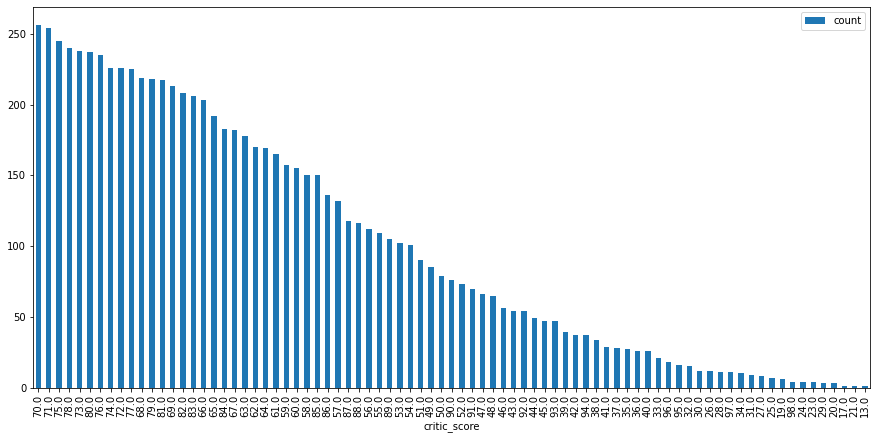

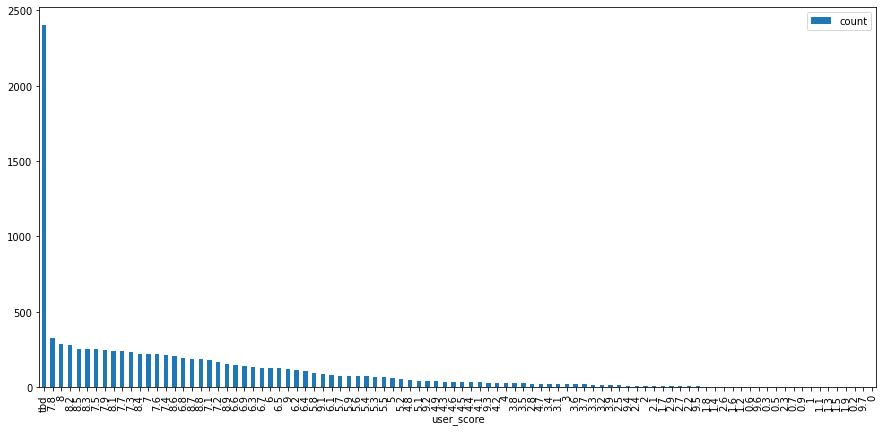

In [28]:
for rating in ['critic_score', 'user_score']:
    f_look_category_feature(data, rating)

По сути признаки числовые. В признаке user_score попало какое-то "tbd" из-за чего тип признака стал object.  
Предположительно tbd = to be detected (determinated, decided...) (типа еще не определен)  
Видно, что critic_score по сути должен быть int (переведем)
А так же Посмотрим распределение признаков

<AxesSubplot:>

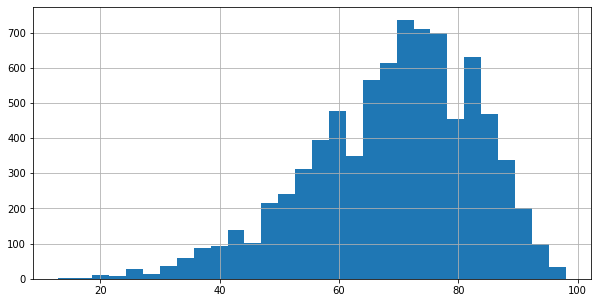

In [29]:
data['critic_score'].hist(bins=30, figsize=(10,5))

Распределение близко к нормальному, максимум примерно на 70, смещение распределения вправо (хвост влево).

<AxesSubplot:>

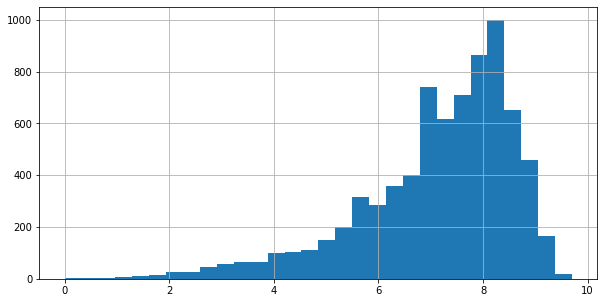

In [30]:
# чтобы посмотреть на второй признак надо сначала избавиться от 'tbd', nan, и перевести в числовой формат
data[(data['user_score'] != 'tbd')&(~data['user_score'].isna())]['user_score'].astype('float').hist(bins = 30, figsize=(10,5))

Распределение похоже на предыдущее. Близко к нормальному, смещение вправо (хвост вытянут влево). Пик чуть больше 8.

Избавимся от пропусков. Удалять нецелесообразно - большой пласт информации, поэтому поставим заглушку: все nan и tbd заменим на -1. Переведем второй признак в числовой формат, а первый в тип int

In [31]:
data['critic_score'].fillna(-1, inplace=True)
data['user_score'].fillna(-1, inplace=True)
data.loc[data['user_score']=='tbd', 'user_score'] = -1
data['critic_score'] = data['critic_score'].astype(int)
data['user_score'] = data['user_score'].astype(float)

In [32]:
# Посмотрим корреляцию между признаками (за исключением неопределенных -1)
data[(data['critic_score']!=-1)|((data['user_score']!=-1)) ][['critic_score', 'user_score']].corr()

,critic_score,user_score
critic_score,1.000000,0.241319
user_score,0.241319,1.000000


Корреляция есть. Прямая, существенная, но от единицы далека. Если оставить -1 - то корреляция 0.8 (что объясняется большим количеством пропусков)

**rating**  
Рейтинг ESRB

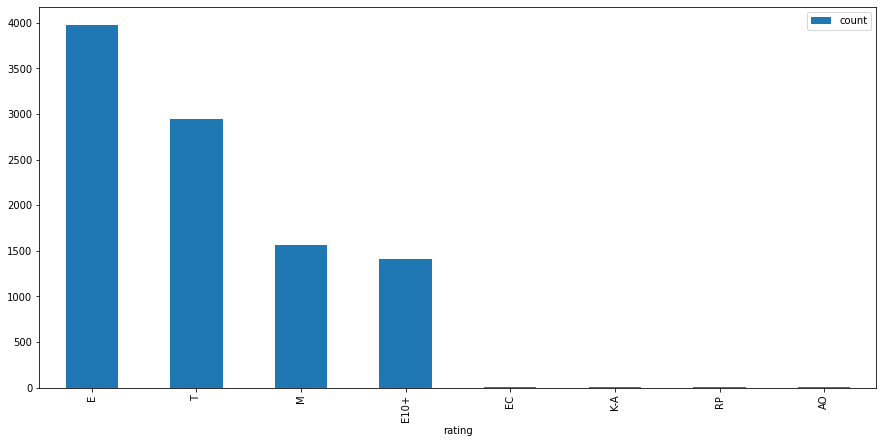

In [33]:
f_look_category_feature(data, 'rating')

«T» («Teen») — «Подросткам 13—19 лет»: Игра подходит для подростков старше 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.  
«E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории старше 6 лет; такие игры могут понравиться и взрослым.  
«E10+» («Everyone 10 and older») — «Для всех старше 10 лет»  
«M» («Mature») — «От 17 лет»: Материалы игры не подходят для возрастной категории младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику

Остальные рейтинги столь незначительны, так что мы их переименуем в other  
Пропуски заполним unknown

In [34]:
data.loc[data['rating'].isin(['EC', 'K-A', 'RP', 'AO']), 'rating'] = 'other'
data.loc[data['rating'].isna(), 'rating'] = 'uknown'

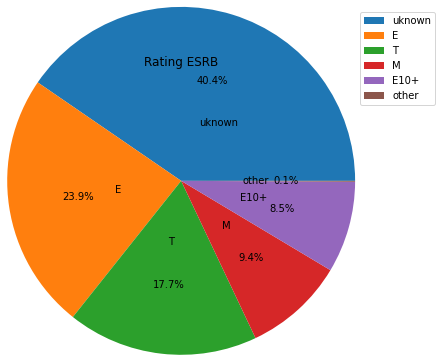

In [35]:
# Посмотрим получившийся пирожок по рейтингу ESRB
data['rating'].value_counts().plot(kind='pie', 
                                   autopct='%1.1f%%', 
                                   radius=2.0, 
                                   ylabel = '',
                                   title = 'Rating ESRB',
                                   labeldistance=0.35,
                                   ).legend(bbox_to_anchor=(1.3, 1.3));

**Предварительный вывод**  
На этом шаге мы провели следующую предобработку:  
- Заменили названия столбцов (приведили к нижнему регистру);
- Преобразовали в int 'year_of_release' и 'critic_score' (float был излишним). Признаки о продажах тип не меняли, можно было бы перевести из  миллионов перевести в шт. и сделать так же int но решили оставить как есть. Признак  'critic_score' перевели во float, так как у оценок вещественный тип (нецелое)
- Заполнили пропуски признака 'year_of_release' частично спарсенными данными, частично из названия игр, частично по имеющимся о таких играх данных для разработанных для других платформ (остаток удалили). В признаках critic_score, user_score, rating на пропуски поставили заглушки, так получить такие данные довольно сложно (можно было бы поискать рейтинги на различных сайтах и спарсить их оттуда, но это не укладывается в рамки работы, предполагаю что парсить пришлось бы не один сайт). Заполнять же такое кол-во пропуссков медианой или средним - нецелесообразно, лучше добавить категориальный признак (есть рейтинг или нет) 
Возможно пропуски вызваны техничесским сбоем, возможно часть игр просто не оценивалась критиками и игроками (а может комбинация причин)
- при обработке пропусков обратили внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Также поставили на него заглушку, так по сути данных по таким играм нет;
- добавили вспомагательные столбцы: total_sales (суммарная продажа во всех регионах) и unpopular(игра отсутствует в оценке критиков и пользователей)


In [36]:
# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16640 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16640 non-null  object 
 1   platform         16640 non-null  object 
 2   year_of_release  16640 non-null  int64  
 3   genre            16640 non-null  object 
 4   na_sales         16640 non-null  float64
 5   eu_sales         16640 non-null  float64
 6   jp_sales         16640 non-null  float64
 7   other_sales      16640 non-null  float64
 8   critic_score     16640 non-null  int64  
 9   user_score       16640 non-null  float64
 10  rating           16640 non-null  object 
 11  unpopular        16640 non-null  bool   
 12  total_sales      16640 non-null  float64
dtypes: bool(1), float64(6), int64(2), object(4)
memory usage: 2.2+ MB


### Исследовательский анализ данных. Посмотрим различные закономерности между признаками.  

<AxesSubplot:>

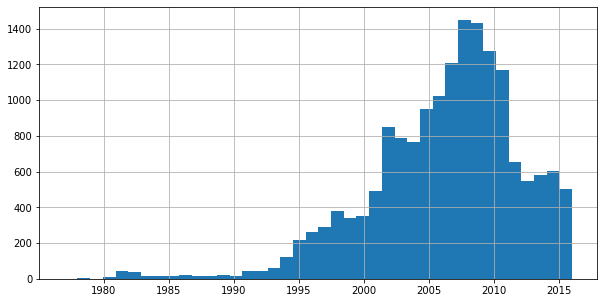

In [37]:
# Посмотрим, сколько игр выпускалось в разные годы. 
data['year_of_release'].hist(bins = 40, figsize=(10,5))

Пик выпуска игр пришелся на 2005-2010 годы. Для анализа и бюджетипрования следующих периодов я бы сконцентрировался на последних годах. Рост наметился примерно с 1995 года, более старые игры я бы точно не рассматривал. 

**platform**  
у нас 31 уникальная игровая платформа за представленный в датасете период.

<AxesSubplot:xlabel='platform'>

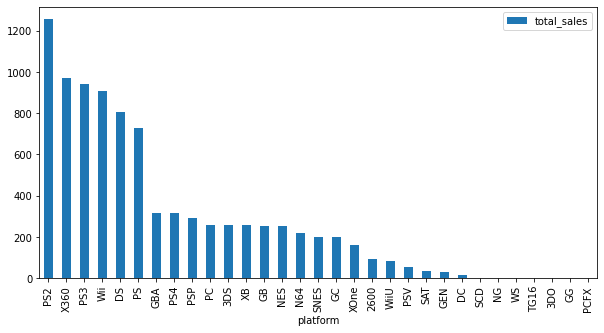

In [38]:
# Посмотрим, какие платформы были наиболее популярны в продажах
gr_platforms = data.groupby('platform').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False)
gr_platforms.plot(kind='bar', figsize=(10,5))

In [39]:
# Поступим по принципу Паррето (20% приносят 80% результата). 
# Будем считать платформы с наибольшими продажами те, у которых продажи суммарно составляют 80%
gr_platforms[:12].sum()/gr_platforms.sum()


total_sales    0.820799
dtype: float64

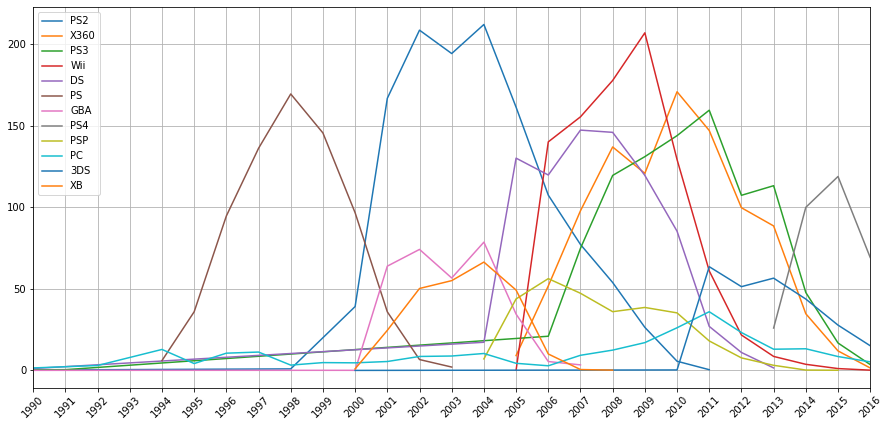

In [40]:
# Будем считать наиболее эффективными дюжину платформ, которые приносят более всего продаж
pop_platforms = gr_platforms[:12].index.to_list()

# Посмотрим как эти платформы вели себя по годам
make_plot(data, 'platform')

Получили очень "наглядный график" по платформам по годам. Нижние пороги обрезал до 0.1 квантиля. В принципе можно из графика понять, что при планировании на следующий год можно обрезать из этих платформ PS, PS2, XB, GBA - видно, что их популярность уже закончилась. Соответственно и год можно для анализа обрезать до 2011-го, чтобы не тянуть за собой устаревшие исторические зависимости и исключить из анализа устаревшие игры, жанры, платформы. 

Ответить на вопрос: за какой характерный срок появляются новые и исчезают старые платформы? из графика конечно можно, но не очень наглядно. Чуть пошаманим



In [41]:
# Сгруппируем по платформам в отдельный датафрейм
df_gr_platform = data.groupby('platform').agg({'year_of_release':['max', 'min']})
# добавим столбец с разницей
df_gr_platform['diff_year'] = df_gr_platform.iloc[:,0] - df_gr_platform.iloc[:,1]
df_gr_platform['diff_year'].describe()

count    31.000000
mean      9.709677
std       8.664847
min       0.000000
25%       3.000000
50%       8.000000
75%      11.500000
max      31.000000
Name: diff_year, dtype: float64

В общем по медиане можно сказать что продолжительность жизни платформы 8 лет, 1й и 3й квантиль - 3 и 11.5 лет соответственно. Чтобы не зацепить устаревшие закономерности возьмем данные как половину от медианы (+последний неполный год), то есть с 2011 года

In [42]:
df_gr_platform.loc[pop_platforms]

year_of_release       diff_year
                     max   min          
platform                                
PS2                 2011  1989        22
X360                2016  2005        11
PS3                 2016  1988        28
Wii                 2016  2005        11
DS                  2013  1985        28
PS                  2003  1994         9
GBA                 2007  1984        23
PS4                 2016  2013         3
PSP                 2015  2004        11
PC                  2016  1985        31
3DS                 2016  2000        16
XB                  2008  2000         8

Кстати, видим аномалию. В PS3 первая игра - 1988 году, хотя платформа вышла в 2006 году. Проверим

In [43]:
data[((data['platform']=='PS3')&(data['year_of_release']<2006))]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,unpopular,total_sales
4127,Sonic the Hedgehog,PS3,1991,Platform,0.00,0.48,0.0,0.00,43,4.1,E10+,False,0.48
8500,Splatterhouse,PS3,1988,Action,0.13,0.02,0.0,0.02,59,7.7,M,False,0.17


Хорошо, что заметили эту аномалию.
Проверим на всякий случай и другие платформы. Парсить не будем - платформ не много, качаем навык гуглениия:  
PS2 - 2000  
PS3 - 2006  
X360 - 2005  
Wii - 2006  
DS - 2004  
PS - 1994  
PS4 - 2013  
3DS - 2011  
XB - 2001  

Однако. Видим, что аномалии есть и на других платформах. Уберем

In [44]:
# Уберем аномальные игры
platf_dict = {'PS2':2000,
              'PS3':2006,
              'X360':2005,
              'Wii':2006,
              'DS':2004,
              'PS':1994,
              'PS4':2013,
              '3DS':2011,
              'XB':2001}

for i,j in platf_dict.items():
    data = data[~((data['platform']==i)&(data['year_of_release']<j))]

In [45]:
df_gr_platform.loc[pop_platforms]

year_of_release       diff_year
                     max   min          
platform                                
PS2                 2011  1989        22
X360                2016  2005        11
PS3                 2016  1988        28
Wii                 2016  2005        11
DS                  2013  1985        28
PS                  2003  1994         9
GBA                 2007  1984        23
PS4                 2016  2013         3
PSP                 2015  2004        11
PC                  2016  1985        31
3DS                 2016  2000        16
XB                  2008  2000         8

Здесь более наглядно, чем на графике видно, что от платформ PS, PS2, DS, XB, GBA - можно отказаться при анализе на следующий год, так как максимальный год, когда на них выпускались игры - до 2013 года.  
Можно конечно еще убрать и PSP, но вдруг на него просто нет данных, последняя игра на неё была в 2015-м. Оставим.  

Итак, оставим себе для анализа данные по выбранным платформам

In [46]:

for x in ['PS', 'PS2', 'DS', 'XB', 'GBA']:
    try:
        pop_platforms.remove(x)
    except:
        continue

data = data[(data['platform'].isin(pop_platforms))&(data['year_of_release']>=2011)]
data.shape

(3040, 13)

Посмотрим, какие из выбранных платформ наиболее прибыльные

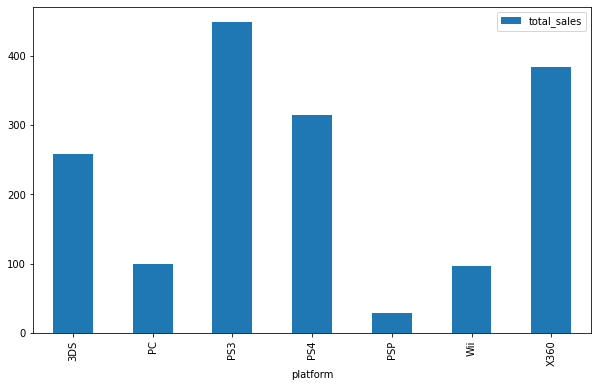

In [47]:
(
data.groupby('platform').agg({'total_sales': 'sum'})
    .plot(kind='bar', figsize=(10,6))
);

Наиболее прибыльными являются последние плойки PS3 и PS4, а также X360. Но логика подсказывает, что возможно у них уже был пик продаж, а сейчас спад. Возможно наоборот стоит обратить внимание на более развивающиеся платформы.  

Посмотрим по этим платформам график по годам.

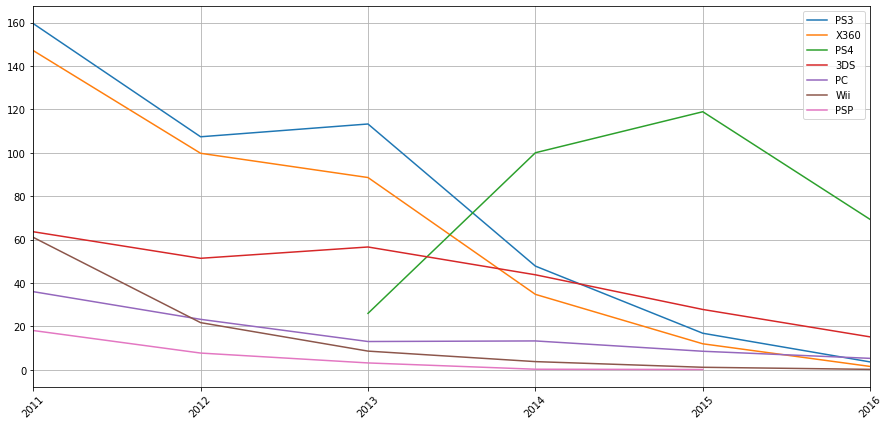

In [48]:
make_plot(data, 'platform', year_min=2011, lim=0)

При меньшем количестве платформ смотреть уже удобнее. Видим тренд на снижение по всем игровым платформам. Возможно это обусловлено большей популяризацией игр на телефонах (развитие смартфонов как раз началось где то в те годы)

Причем, чем больше продаж было всего на платформе, тем более резкий спад имеем к 2016му году.  
Отметить хочется только последнюю плойку PS4, возможно год не полный - и такого падения в итоге по ней не будет. Да и появилась она незадолго до бюджетируемого года, вобщем очень перспективная.

Text(0.5, 1.0, 'популярные платформы')

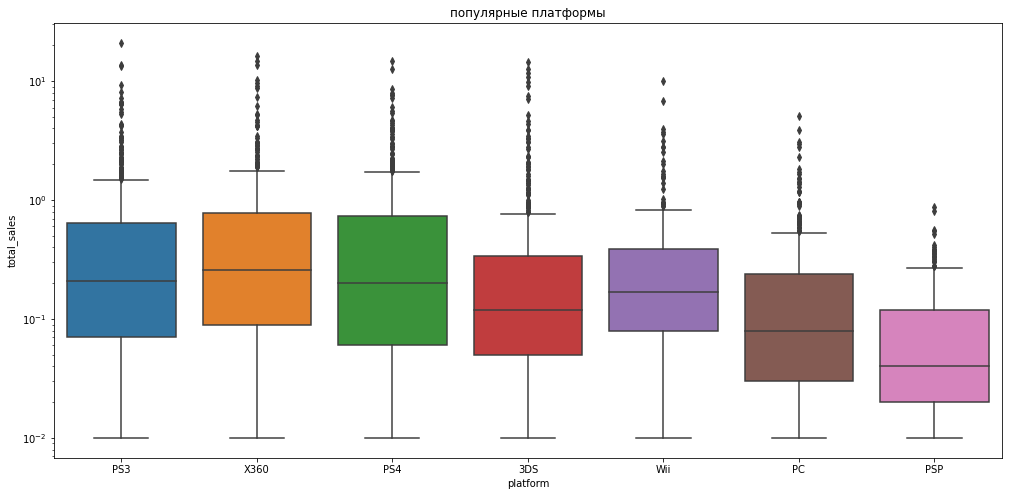

In [49]:
# Посмотрим на боксплоты по этим платформам
plt.figure(figsize=(17, 8))
sns.boxplot(data['platform'], data['total_sales'])
plt.yscale('log')
plt.title('популярные платформы')

Я бы не сказал, что по боксплотам ярко выражено преобладание тех или иных платформ. Чуть Выделяются в лучшую сторону X360, PS3, PS4. А вот PSP опять обращает на себя внимание в плане отказа от включения в стратегию 2017го года.

Посмотрим, как влияют на продажи внутри платформ отзывы пользователей и критиков.
Построим диаграммы рассеяния и посчитаем корреляцию между отзывами и продажами.

**продажи vs критики**

Корреляция по платформе X360:


,critic_score
total_sales,0.39


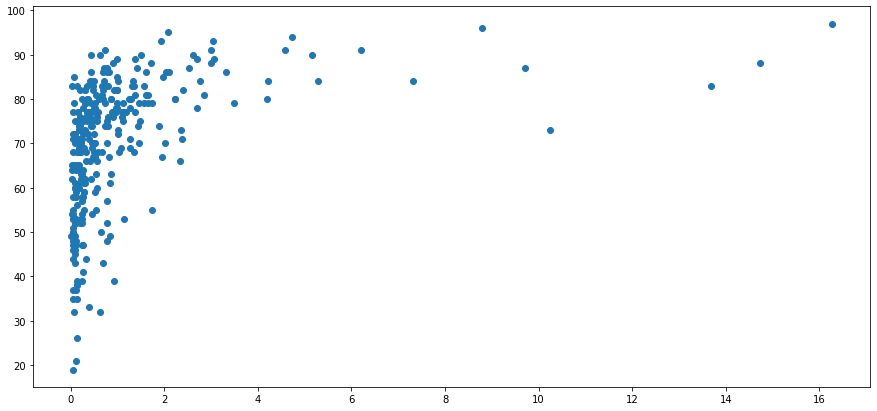

Корреляция по платформе PS3:


,critic_score
total_sales,0.38


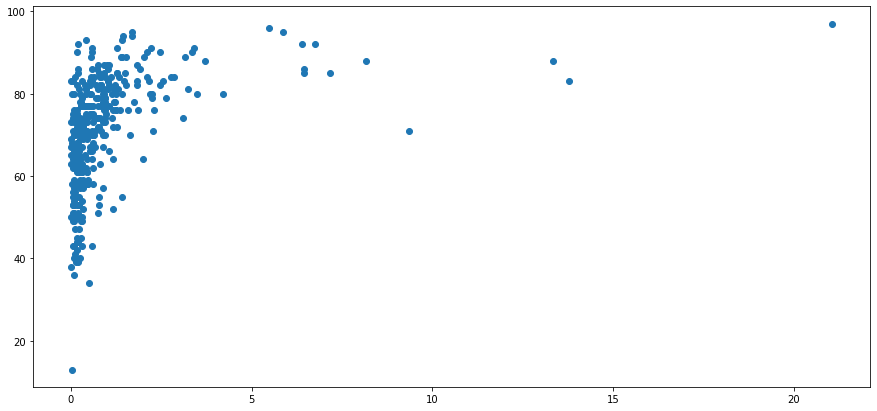

Корреляция по платформе Wii:


,critic_score
total_sales,0.3


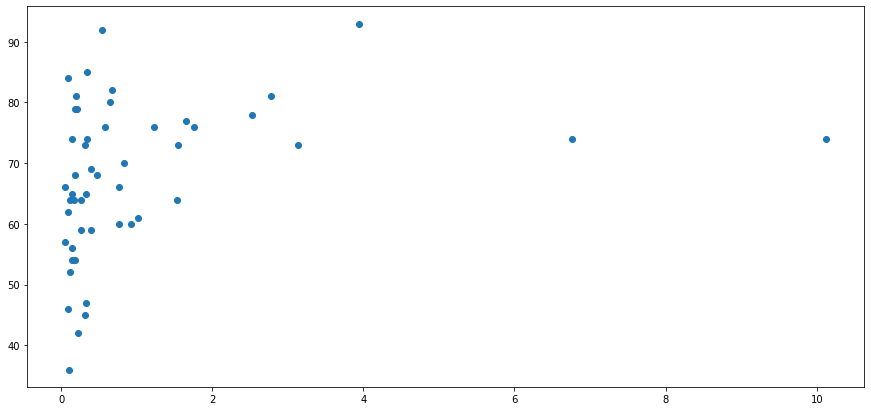

Корреляция по платформе PS4:


,critic_score
total_sales,0.41


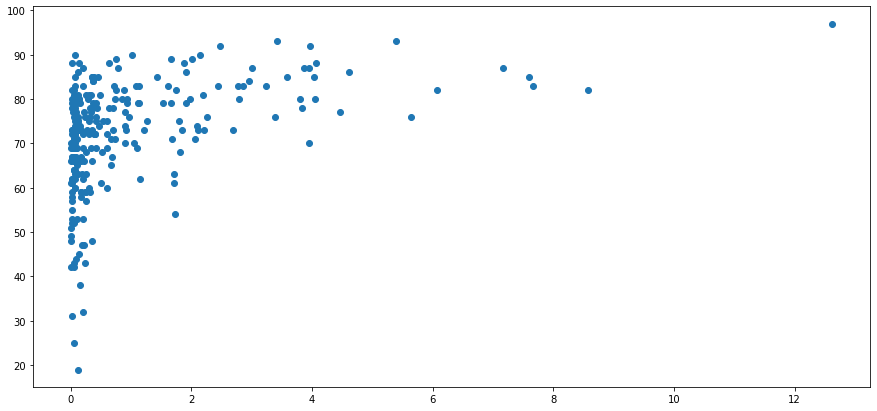

Корреляция по платформе PSP:


,critic_score
total_sales,0.36


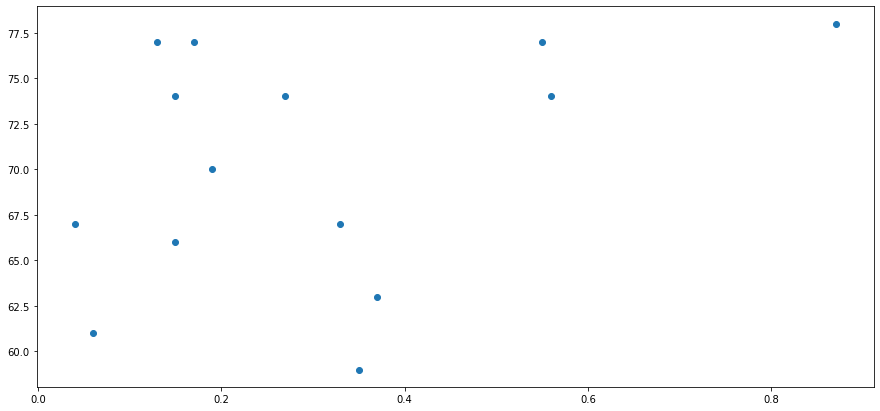

Корреляция по платформе PC:


,critic_score
total_sales,0.32


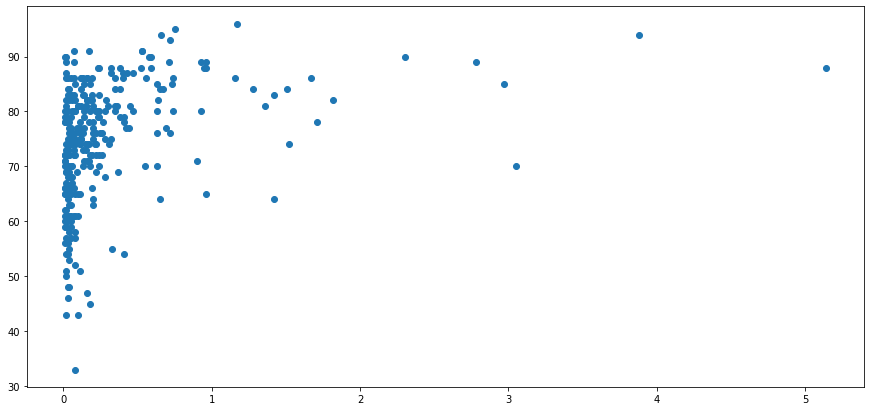

Корреляция по платформе 3DS:


,critic_score
total_sales,0.35


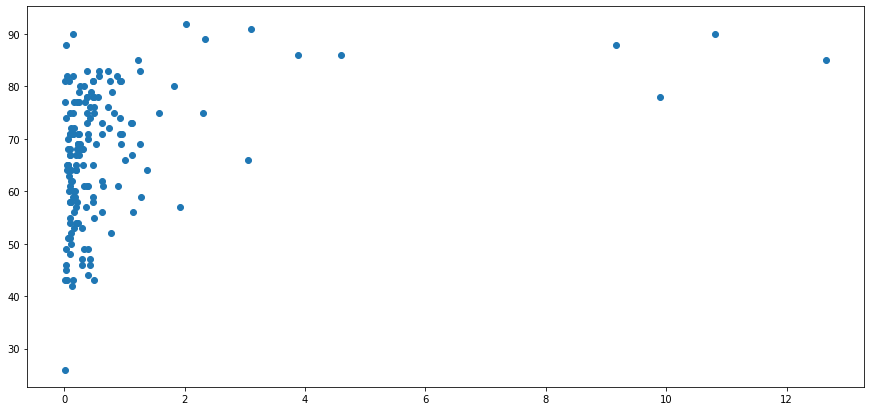

In [50]:
corr_features = ['total_sales', 'critic_score']

for platform in pop_platforms:
    
    df_pl = (data[(data['platform']==platform)
                 &(data['critic_score']>-1)]
            [['total_sales', 'critic_score']]
            )
    
    print(f'Корреляция по платформе {platform}:')
    display(df_pl.corr().iloc[:1,1:].round(2))
    
    plt.figure(figsize=(15,7))
    
    plt.scatter(data[(data['platform']==platform)&(data['critic_score']>-1)]['total_sales'], 
            data[(data['platform']==platform)&(data['critic_score']>-1)]['critic_score'])
    
    plt.show()


**продажи vs юзеры**

Корреляция по платформе X360:


,user_score
total_sales,0.04


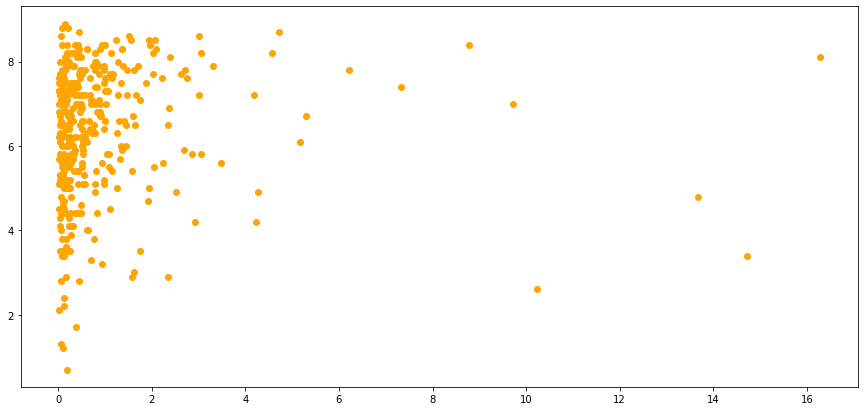

Корреляция по платформе PS3:


,user_score
total_sales,0.01


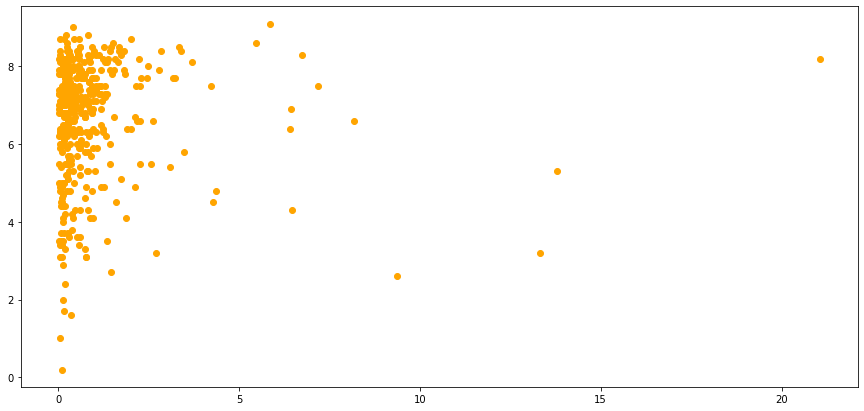

Корреляция по платформе Wii:


,user_score
total_sales,0.15


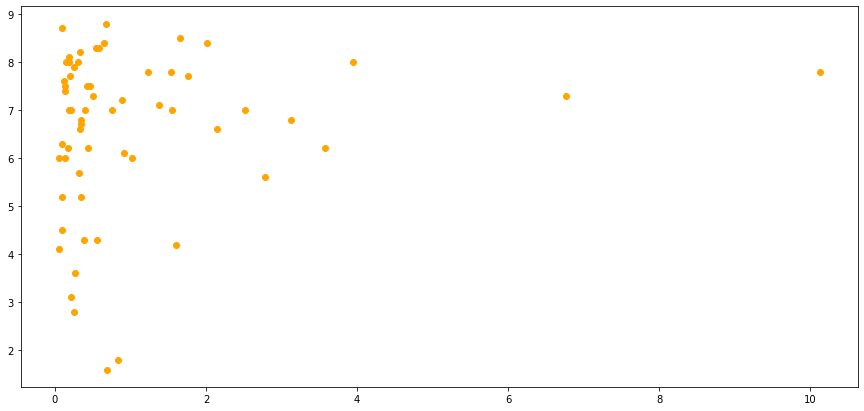

Корреляция по платформе PS4:


,user_score
total_sales,-0.03


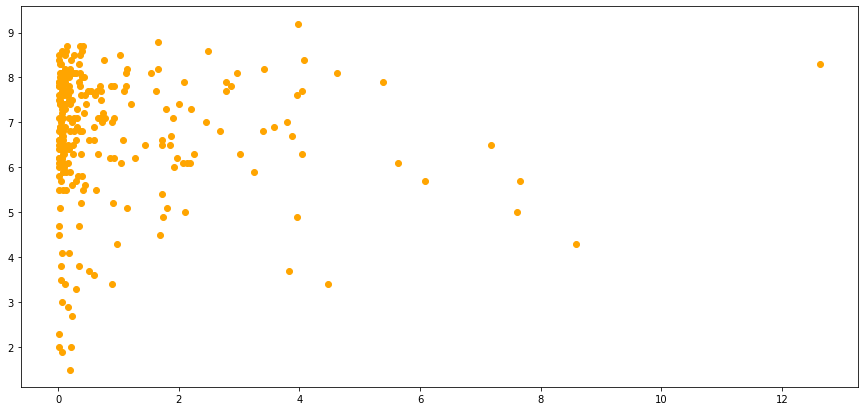

Корреляция по платформе PSP:


,user_score
total_sales,0.01


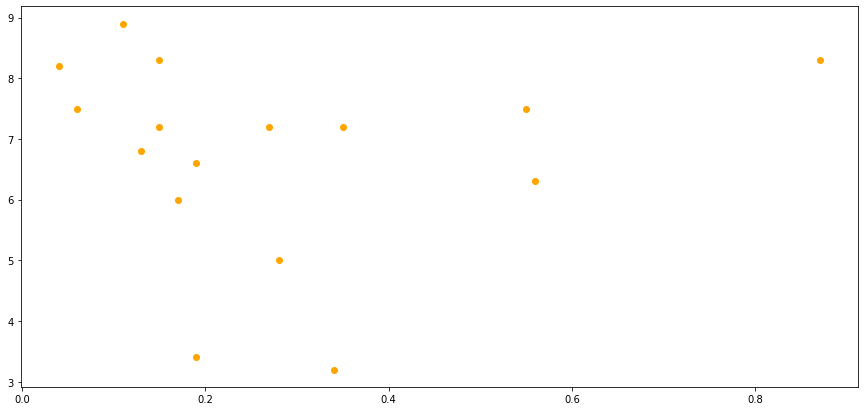

Корреляция по платформе PC:


,user_score
total_sales,-0.05


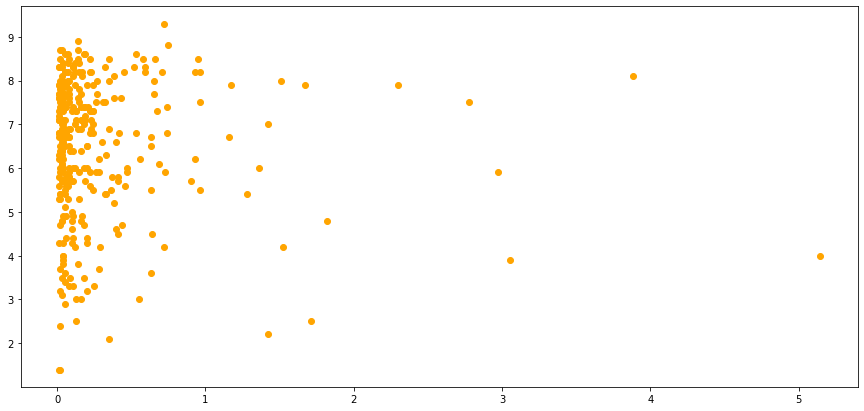

Корреляция по платформе 3DS:


,user_score
total_sales,0.22


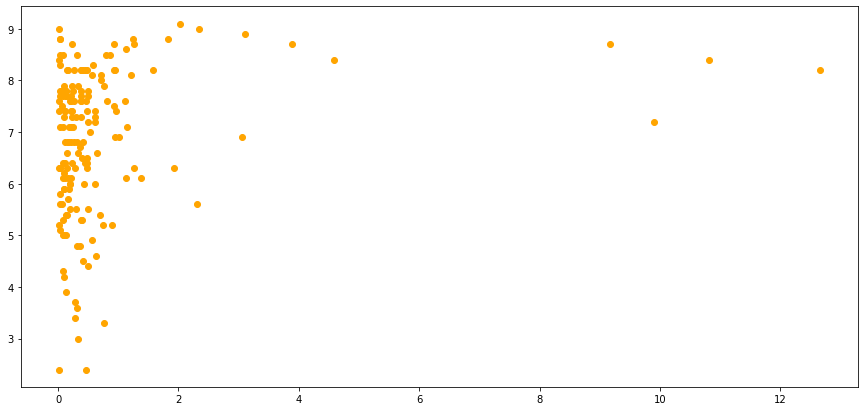

In [51]:
corr_features = ['total_sales', 'user_score']

for platform in pop_platforms:
    
    df_pl = (data[(data['platform']==platform)
                 &(data['user_score']>-1)]
            [['total_sales', 'user_score']]
            )
    
    print(f'Корреляция по платформе {platform}:')
    display(df_pl.corr().iloc[:1,1:].round(2))
    
    plt.figure(figsize=(15,7))
    
    plt.scatter(data[(data['platform']==platform)&(data['user_score']>-1)]['total_sales'], 
            data[(data['platform']==platform)&(data['user_score']>-1)]['user_score'], color='orange')
    
    plt.show()

Из графиков видно, что корреляция тотальных продаж выше с оценкой критиков, чем с оценкой пользователей и состтавляет 0.3-0.4.
Выбивается только корреляция по платформе Wii (самая низкая 0.17 у критиков и 0.11 у пользователей).
Корреляция продаж с отзывами пользователей на платформах: PC и PS4 можно сказать вообще отсутствует.

Посмотрим еще раз на жанры игр

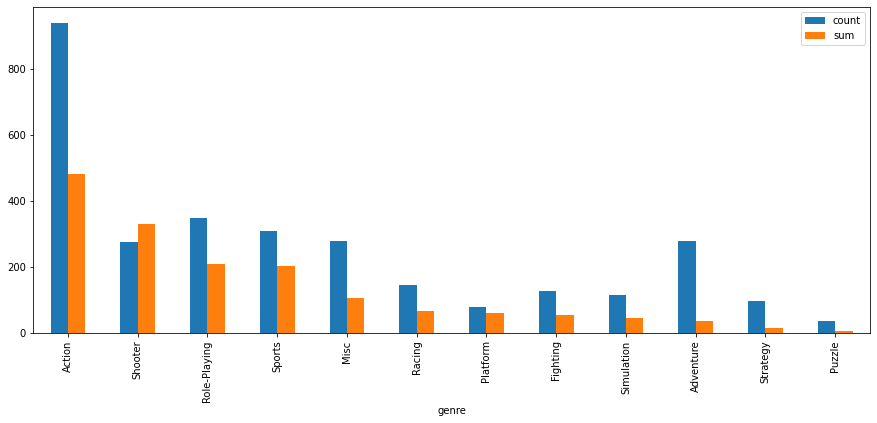

In [52]:
(
data.groupby('genre')['total_sales'].agg(['count', 'sum'])
    .sort_values(by='sum', ascending=False)
    .plot(kind='bar', figsize=(15,6))
);

Видно, что такие жанры как Action, Sports, Shooter, Misc, RPG имеют более высокие продажи, чем другие. Меньше всего продаж у стретегий и паззлов.

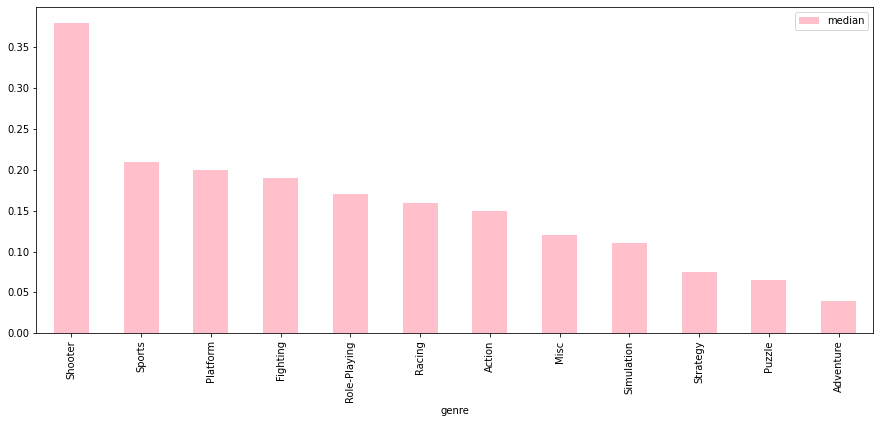

In [53]:
(
data.groupby('genre')['total_sales'].agg(['median'])
    .sort_values(by='median', ascending=False)
    .plot(kind='bar', figsize=(15,6), color='pink')
);


А вот в медианных продажах в лидеры вырвались шутеры, Action же съехал во вторую половину списка

**предварительный вывод**  
На этом шаге мы провели исследовательский анализ данных
- Игровая индустрия начала бурно развиваться в начале 90х годов, пик пришелся на 2005-2010 год. На самом деле можно предположить, что индустрия развивается и сейчас, просто в датасет не попали данные для играх на телефонах, так бы возможно мы увидели дальнейший рост развития индустрии.
Определили, что для анализа данных объективно брать данные начиная с 2011 года, более старые игры - устарели вместе с платформами.
- Определили наиболее перспективные платформы на которых выпускаются игры в последние годы. Опеределили срок жизни платформ, который составил 8 лет (медианный)
- Посмотрели корреляцию между продажами игр и оценкой пользователей и критиков. Выявили существенную корреляцию между продажами и оценкой критиков на уровне 0.3 - 0.4.
- Определили жанры игр, которые приносят наибольшую прибыль. (в целом и на одну игру). Определили, что наиболее прибыльными являются Action, Sports, Shooter, Misc, RPG, причем у Shooter-ов еще и наибольшая медианная прибыльность.

### Составим портрет пользователя в зависимости от региона (NA, EU, JP). 

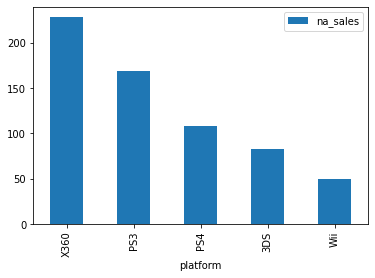

,percents
platform,
X360,35.8
PS3,26.5
PS4,17.0
3DS,13.0
Wii,7.7


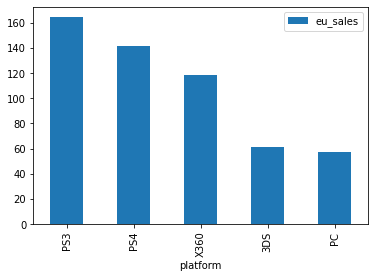

,percents
platform,
PS3,30.3
PS4,26.0
X360,21.8
3DS,11.3
PC,10.6


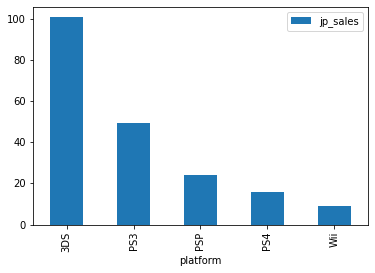

,percents
platform,
3DS,50.6
PS3,24.8
PSP,12.1
PS4,8.0
Wii,4.5


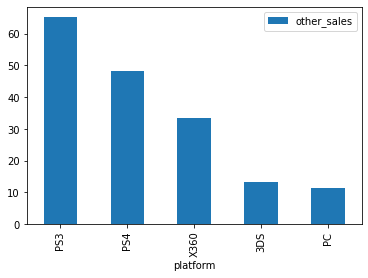

,percents
platform,
PS3,38.0
PS4,28.2
X360,19.5
3DS,7.7
PC,6.6


In [54]:
#Самые популярные платформы (топ-5) для каждого региона.
region_sales = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for region in region_sales:
    check_region(data, region, 'platform')

Видим, что во всех регионах в лидеры попали PS3, PS4, Wii. Так же популярна платформа X360, ее нет только в японии. Так же отметим, что япония пошла своим путем, у них в фаворе Платформа 3DS, кторая больше не отметилась в топах других регионов

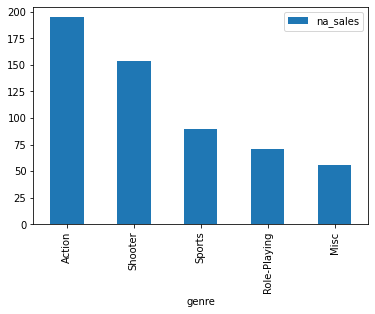

,percents
genre,
Action,34.5
Shooter,27.2
Sports,15.9
Role-Playing,12.6
Misc,9.8


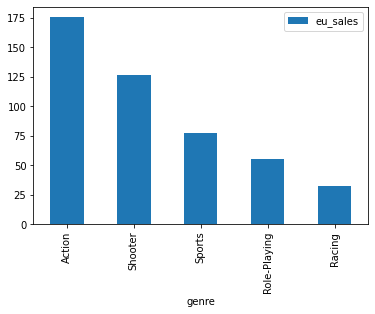

,percents
genre,
Action,37.5
Shooter,27.1
Sports,16.6
Role-Playing,11.8
Racing,7.0


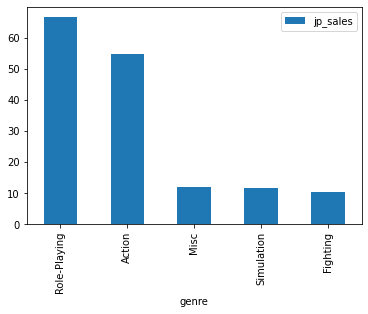

,percents
genre,
Role-Playing,42.9
Action,35.3
Misc,7.8
Simulation,7.4
Fighting,6.6


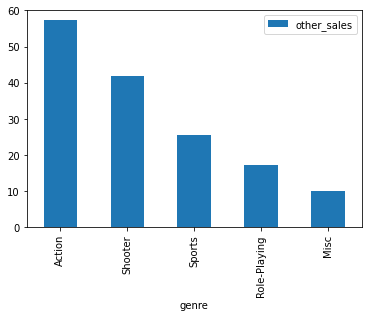

,percents
genre,
Action,37.7
Shooter,27.6
Sports,16.9
Role-Playing,11.3
Misc,6.5


In [55]:
#Самые популярные жанры (топ-5) для каждого региона.

for region in region_sales:
    check_region(data, region, 'genre')

В пятерку жанров вошли Action (30%), Sports и Shooter(примерно 23% кроме японии), Misc(11%-15%). Немного выделилиась япония - у них в фаворе RPG занимает почти 40%. Очевидно японцы, как поклонниики Анимэ большее предпочтение отдают ролевым играм. 

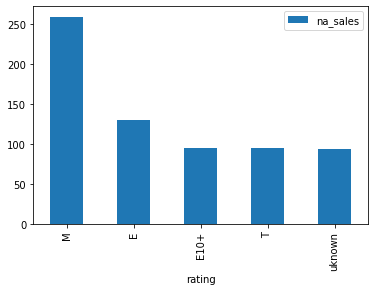

,percents
rating,
M,38.6
E,19.3
E10+,14.1
T,14.0
uknown,14.0


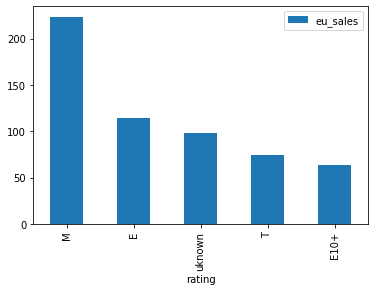

,percents
rating,
M,38.9
E,20.0
uknown,17.0
T,13.0
E10+,11.1


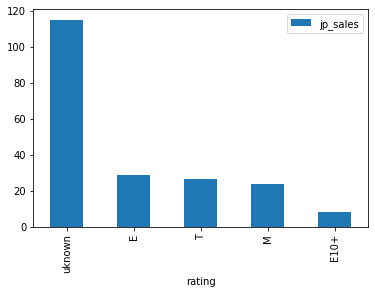

,percents
rating,
uknown,56.9
E,14.2
T,13.2
M,11.7
E10+,4.0


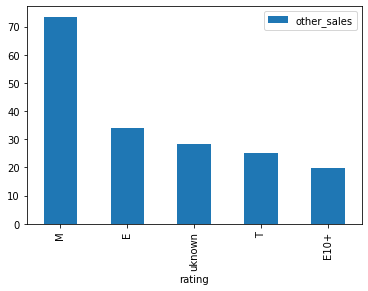

,percents
rating,
M,40.7
E,18.7
uknown,15.7
T,13.9
E10+,11.0


In [56]:
#Проверим влияет ли рейтинг ESRB на продажи в отдельном регионе
for region in region_sales:
    check_region(data, region, 'rating')

Везде отметились такие оценки ESRB как E(для всех) M(для взрослых) T(подросткам). В японии преобладание неоцененных рейтингом ESRB игр. Опять выделились, играют во что то своё.


**Предварительный вывод**  
На данном этапе мы посмотрели предпочтения потребителей в зависимости от региона потребления. Есть и общие тенденции, есть и различия между ними.Выделяется страна восходящего солнца, которая идет своим путем.

### Проверим гипотезы
 
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
```
H_0: Средние пользовательские рейтинги (user_score) платформ Xbox One и PC равны`
H_a: Средние пользовательские рейтинги (user_score) платформ Xbox One и PC не равны`
alpha = 0.05
```


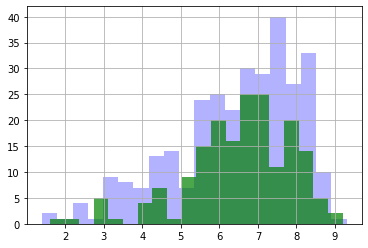

In [57]:
# Так как платформы Xbox One нет среди популярных, то она отсутствует в нашем итоговом датасете. Возьмем ее из начального
xbox = (
        df[(df['Platform']=='XOne')
           &(~df['User_Score'].isna())
           &(df['User_Score'] != 'tbd')
           &(df['Year_of_Release'] >= 2011)]['User_Score'].astype(float)
        )
# Данные по PC так же возбмем из начального
pc =   (
        df[(df['Platform']=='PC')
           &(~df['User_Score'].isna())
           &(df['User_Score'] != 'tbd')
           &(df['Year_of_Release'] >= 2011)]['User_Score'].astype(float)
        )

#  И посмотрим на распределение
pc.hist(bins=20, alpha=0.3, color='blue')
xbox.hist(bins=20, alpha=0.7, color='green');

По распределению видно, что максимум по оценкам приходится  в PC примерно на 8, в Xbox на 7.

In [58]:
# Посмотрим меры для платформ
print_mesures(pc)
print_mesures(xbox)

Меры для pc 
     медиана - 6.8
     среднее - 6.45
     минимум - 1.4
     максимум - 9.3
     стандартное отклонение - 1.61
     
------------------------------------------------------------
Меры для xbox 
     медиана - 6.8
     среднее - 6.52
     минимум - 1.6
     максимум - 9.2
     стандартное отклонение - 1.38
     
------------------------------------------------------------


In [59]:
# Итак, считаем выборки - независмыми, не равными

results = st.ttest_ind(xbox, pc, equal_var = False) # вызов метода для проверки гипотезы
alpha = 0.05 # задаём значение уровня значимости

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.6130712247638477
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу не отвергли, значит с больльшой долей вероятности можно сказать, что средние рейтинги пользователей для платформ Xbox и PC равны

2. Проверим вторую гипотезу, то что Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
```
H_0: Средние пользовательские рейтинги (user_score) жанров Action  и Sports равны`
H_a: Средние пользовательские рейтинги (user_score) жанров Action  и Sports не равны`
alpha = 0.05
```

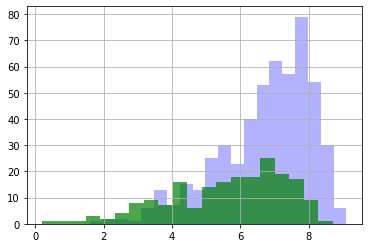

In [60]:
# возьмем выборки для Action и Sports
action = data[(data['genre']=='Action')&(data['user_score'] >-1)]['user_score']
sports = data[(data['genre']=='Sports')&(data['user_score'] >-1)]['user_score']

#  И посмотрим на распределение
action.hist(bins=20, alpha=0.3, color='blue')
sports.hist(bins=20, alpha=0.7, color='green');

Визуально видно, что рейтинги для обоих жанров имеют один пик в районе 8

In [61]:
# Посмотрим меры для данных жанров
print_mesures(action)
print_mesures(sports)

Меры для action 
     медиана - 7.1
     среднее - 6.74
     минимум - 1.6
     максимум - 9.1
     стандартное отклонение - 1.37
     
------------------------------------------------------------
Меры для sports 
     медиана - 6.0
     среднее - 5.62
     минимум - 0.2
     максимум - 8.7
     стандартное отклонение - 1.72
     
------------------------------------------------------------


In [62]:
# Итак, считаем выборки - независмыми, не равными

results = st.ttest_ind(action, sports, equal_var = False) # вызов метода для проверки гипотезы
alpha = 0.05 # задаём значение уровня значимости

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.311405239146084e-14
Отвергаем нулевую гипотезу


Принимаем альтернативную гипотезу, то что средний рейтинг для Action и Sports не равны

**Предварительный вывод**  
Приняли нулевую гипотезу, что средний рейтинг пользователей для Xbox и PC совпадает с высокой долей вероятности.
Опровергли гипотезу о том, что средний рейтинг пользователей для жанров Action и Sports совпадают.

## Общие выводы  

**Провели предварительную обработку данных**  
- Заменили названия столбцов (приведили к нижнему регистру);
- Преобразовали в int 'year_of_release' и 'critic_score' (float был излишним). Признаки о продажах тип не меняли, можно было бы перевести из  миллионов перевести в шт. и сделать так же int но решили оставить как есть. Признак  'critic_score' перевели во float, так как у оценок вещественный тип (нецелое)
- Заполнили пропуски признака 'year_of_release' частично спарсенными данными, частично из названия игр, частично по имеющимся о таких играх данных для разработанных для других платформ (остаток удалили). В признаках critic_score, user_score, rating на пропуски поставили заглушки, так получить такие данные довольно сложно (можно было бы поискать рейтинги на различных сайтах и спарсить их оттуда, но это не укладывается в рамки работы, предполагаю что парсить пришлось бы не один сайт). Заполнять же такое кол-во пропуссков медианой или средним - нецелесообразно, лучше добавить категориальный признак (есть рейтинг или нет) 
Возможно пропуски вызваны техничесским сбоем, возможно часть игр просто не оценивалась критиками и игроками (а может комбинация причин)
- при обработке пропусков обратили внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Также поставили на него заглушку, так по сути данных по таким играм нет;
- добавили вспомагательные столбцы: total_sales (суммарная продажа во всех регионах) и unpopular(игра отсутствует в оценке критиков и пользователей)  
В реальной жизни постарались бы разобраться в причинах пропусков - тех сбой или просто нет данных по некоторым играм. Так же попробовали бы обогатить имеющийся датасет, жизненный опыт подсказывает что упущен существенный пласт игр для мобильных телефонов, возможно, что так же упущены какие то вновь появляющиеся но при этом перспективные платформы. Так же можно было бы побрэйнштормить и нагенерить дополнительных признаков (универсальность платформ, год выпуска платформы, население регионов, разбить население по возрастным группам и т.д.)

**Провели Исследовательский анализ данных**  
- Игровая индустрия начала бурно развиваться в начале 90х годов, пик пришелся на 2005-2010 год. На самом деле можно предположить, что индустрия развивается и сейчас, просто в датасет не попали данные для играх на телефонах, так бы возможно мы увидели дальнейший рост развития индустрии.
Определили, что для анализа данных объективно брать данные начиная с 2011 года, более старые игры - устарели вместе с платформами.
- Определили наиболее перспективные платформы на которых выпускаются игры в последние годы. Опеределили срок жизни платформ, который составил 8 лет (медианный). К наиболее популярным платформам отнесли 'X360', 'PS3', 'Wii', 'PS4', 'PSP', 'PC', '3DS'.
- Посмотрели корреляцию между продажами игр и оценкой пользователей и критиков. Выявили существенную корреляцию между продажами и оценкой критиков на уровне 0.3 - 0.4.
- Определили жанры игр, которые приносят наибольшую прибыль. К ним отнесли Action, Sports, Shooter, Misc, RPG. Причем отметили, что шутеры имеют наибольшую медианную продажу, то есть являются наиболее надёжным вложением.

**Составили портрет пользователя в зависимости от региона (NA, EU, JP)**
На данном этапе мы посмотрели предпочтения потребителей в зависимости от региона потребления. Есть и общие тенденции, есть и различия между ними.Выделяется страна восходящего солнца, которая идет своим путем. Определили, что наибольшей популярностью в японии являются платформа 3DS - портативная платформа и жанр RPG, любовь к которому предположительно можно обосновать любовью к Анимэ, в то время как в других регионах преобладает любовь к плойкам и экшену.

**Проверили гипотезы**
Приняли нулевую гипотезу, что средний рейтинг пользователей для Xbox и PC совпадает с высокой долей вероятности.
Опровергли гипотезу о том, что средний рейтинг пользователей для жанров Action и Sports совпадают.
Можно сделать вывод, что геймерам не всё равно во что играть, но не важно на чем, главное - играть 🙂.

**Для бюджетирования предстоящего года необходимо:**
- обратить внимание, что регионы все таки отличаются друг от друга и соответственно акценты нужно делать на разные игры, платформы, жанры.  
- Обратить внимание, что тренд продаж последних лет имеет снижение


**Рекомендации для дополнительного анализа**
- Поискать альтернативные источники данных и возможно сконцентрироваться на каких-либо новых разработках, так как в четко выражена экономическая тенденция для платформ (внедрение - развитие - стагнация - смерть). В большей степени обратить внимание на более свежие платформы - умирают, вечен только PC )
- Можно поработать над различными стратегиями для бизнеса. Можно диверсифицировать риски и тогда вкладываться в продажу игр для всех выбранных нами популярных платформ и популярных жанров, а можно, например, найти наиболее прибыльные игры в свои периоды, "наинжененрить" на них данных (если дальше попробовать копнуть - всевозможные движки на которых они разработаны, системные требования и т.д.) и построить прогнозную модель для новых игр для определения предстоящих прибылей и будет ли игра хитом и сконцентрироваться на таких играх. 


Данный анализ можно использовать для разработки бизнес-стратегии в продажах игр на предстоящие периоды
